In [6]:
# import qutip packages
from qutip import *
import krotov
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import scipy
from hyperopt import tpe, Trials, fmin, hp
import matplotlib.pyplot as plt

$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

# The Model (FMO with N Sites/Qubits)

# Define the Hamiltonian and Liouvillian

We model our network model based on previous theoretical descriptions of PPCs as a network composed of distinct sites, one of which receives a single excitation (which we choose to be $\ket{1}$ for the time being) and one site to be connected to the Reaction Center/Sink (which we choose to be $\ket{N}$.  The network of $N$ sites is described by the Hamiltonian with hopping parameters fixed by geometry and dipolar structure of site interactions:

$H = \Sigma_{j = 1}^N \hbar \omega_j \sigma_j^+ \sigma_j^- + \Sigma_{j \ne l} \hbar \nu_{j,l} (\sigma_j^- \sigma_l^+ + \sigma_j^+ \sigma_l^-)$

where we define the raising and lowering operators to be $\sigma_j^+ = \ket{j}\bra{0}$ and $\sigma_j^- = \ket{0}\bra{j}$ for site $j$, and state $j$ denoting one excitation in the site $j$ and $\ket{0}$ is the zero excitation states.  $\hbar \omega_j$ are the local site energies and $\nu_{j, l}$ are the coherent tunneling amplitudes between sites $j$ and $l$ (we do not consider microscoping coupling).  Our Hilbert space is actually defined as $N + 2$ states because we define an additional sink state at $\ket{N+1}$.

# Cavity Addition

The system is confined inside an optical cavity in the strong coupling regime with resonance frequency $\omega_c$ where the Jaynes-Cummings model can be adopted. Energy is injected into the system with an external laser pump with frequency $\omega_l$.  We will consider the pump field to be a continuous wave.  We will consider the case where the pump field is turned on at a certain time, which allows us to explore both the stationary response in the CW field as well as transient excitation dynamics.  We consider collinear polarization of the alser field and cavity mode because the extension of the model to pulsed excitation and cross field polarization is similar.  

THe LHC excitation dynamics is characterized by monitoring the mean photon number and second order coherence function of the light leaking out of the cavity.  
The cavity Hamiltonian is given by (where $a^+, a$ denote the cavity photon creation, annhilation operators.

$H = \omega_c a^+ a$

The coherent interaction between the cavity mode and the system is given by (where $g$ is the coupling constant and $\mu_i$ is the projection of the transition dipole moment of a site along the polarization of the cavity mode)

$H_c = \Sigma_{i = 1}^N g \mu_i (\sigma_i^+ a + \sigma_i^- a^+)$

Additionally, we couple the Hamiltonian with an external laser field:
$H_l(t) = -\Sigma_{i = 1}^N \mu_i E(\omega, t)\sigma_i^+ + h.c.$

We assume that the system is susceptible simultaneously to two distinct types of noise: a radiative decay process that transfers the excitation energy in site j to the environment with a rate $\Gamma_j$ and a pure dephasing process with rate $\gamma_j$ that destroyes phase coherence for localized excitations.  We model the system's density matrix by a Markovian Lindbladian Master Equation:

$\dot{\rho} = -i[H, \rho] + \mathcal{L}_{rad}(\rho)+ \mathcal{L}_{deph}(\rho)$

where we define the local radiative and dephasing terms by the Lindblad superoperators $\mathcal{L}_{rad}$ and $\mathcal{L}_{deph}$:

$\mathcal{L}_{deph} = \Sigma_{j = 1}^N\gamma_j[-\{\sigma_j^+ \sigma_j^-, \rho\} + 2\sigma_j^+ \sigma_j^- \rho \sigma_j^+ \sigma_j^-]$

$\mathcal{L}_{diss}(\rho) = \Sigma_{j = 1}^N\Gamma_j[-\{\sigma_j^+ \sigma_j^-, \rho\} + 2\sigma_j^- \rho \sigma_j^+])$

where $\{A, B\}$ describes an anticommutator relation.

We include an additional relaxation through the interaction with the cavity that has a damping channel described by the Lindbladian:

$\mathcal{L}_{C}(\rho) = \Gamma_C/2[-\{a^+ a, \rho\} + 2a \rho a^+])$

We measure the total excitation transfer by the population transferred to the Reaction Center, which we model as the sink node as $N + 1$ that is populated by an irreversible decay process with rate $\Gamma_{N+ 1}$ from a site $k$ (which we choose to be $\ket{N}$ and described by a Lindblad operator:

 $\mathcal{L}_{sink}(\rho) = \Gamma_c[2 \sigma_c^+ \sigma_k^- \rho \sigma_k^+ \sigma_c^- - \{\sigma_k^+ \sigma_c^- \sigma_c^+, \rho \}]))$

Our objective is to measure the excitation transfer by measuring the population to the sink.  The sink population is modeled by $p_{sink}(t) = 2\Gamma_c \int_0^t\rho_{kk}(t') dt'$.

# Problem Parameters

Here we use units where ℏ=1:

In [18]:
# define units for the problem
hbar = 1;

In [19]:
# define FMO system for initial state excited at state 1
#input:

# N = number of sites, site N + 1 being the sink, and a site 0 being the zero exciton state, 
# thus giving a Hilbert space of N + 2
# M = number of cavity fock states 
# wc = cavity frequency 
# g = coupling constant 
# use_rwa = use the rwa approximation (true/false)
# mu = projection of transition dipole moment of single site along polarization of cavity mode
# omega = local site energies, given in an array of length N
# nu = coherent tunneling amplitude between site i and j, where i,j are from 1 to N, given as an NxN symmetric matrix
# Gamma = rate or radiative decay process that transfers excitation in site j to environment, given as array of length N
# gamma = rate of pure dephasing that destroys phase coherence for localized excitations, given as array of length N
# Gamma_c = rate of irreversible decay from site k to sink, given as double 
# tlist = evolution time

def FMO_solve(N, M, g, wc, mu, use_rwa, omega, nu, Gamma, gamma, Gamma_c, cavity_Gamma, tlist):
    
    # describe vacuum state for sites 
    vac = qutip.basis(N + 2, 0)
    # describe vacuum state for cavity photons with M cavity fock states
    vac_C = qutip.basis(M, 0)
    
    # create raising and lowering operators 
    a = qutip.tensor(destroy(M), qutip.qeye(N + 2))
    
    # raising and lowering operators for each site
    def raise_operator(j):
        siteState = qutip.basis(N + 2, j)
        return qutip.tensor(qutip.qeye(M), siteState * vac.dag())
    
    def lower_operator(j):
        siteState = qutip.basis(N + 2, j)
        return qutip.tensor(qutip.qeye(M), vac*siteState.dag())
    
    #define the sink state k and generate density matrix for that state k
    def target_state(k):
        return qutip.ket2dm(raise_operator(k) * (qutip.tensor(vac_C, vac)))
    
    # build Hamiltonian
    H0 = wc * a.dag() * a
    
    # create Hamiltonian summing 
    if use_rwa:
        for i in range(N):
            H = hbar * g * mu * (raise_operator(i + 1) * a + lower_operator(i + 1) * a.dag())
            H0 = H0 + H
        else:
            for i in range(N):
                H = hbar * g * mu * (a.dag() + a) * (lower_operator(i + 1) * raise_operator(i + 1))
                H0 = H0 + H
    
    # create Hamiltonian summing over all sites N and site energies vector omega
    for i in range(N):
        H = hbar * omega[i] / 2 * raise_operator(i + 1) * lower_operator(i + 1)
        
    # create interaction Hamiltonian summing over all sites N given matrix nu for coherent tunneling amplitudes 
    for i in range(N):
        for j in range(N):
            if (i != j):
                    H = hbar * nu[i,j] * (lower_operator(j + 1) * raise_operator(i + 1) + raise_operator(j + 1) * lower_operator(i + 1))
                    H0 = H0 + H
                    
    # define initial density matrix for initial state, which we take to be |1>
    rho0 = qutip.ket2dm(raise_operator(1) * (qutip.tensor(vac_C, vac)))
                    
    # define Liouvillian for coupled 2-site system
    
    # Define collapse operators
    c_ops_list = []
    # add radiative and dephasing dissipation
    for i in range(N):
        c_ops_list.append(np.sqrt(2 * Gamma[i]) * lower_operator(i + 1)) # radiative
        c_ops_list.append(np.sqrt(2 * gamma[i]) * raise_operator(i + 1) * lower_operator(i + 1)) # dephasing
    # add sink Lindblad collapse 
    k = N
    c_ops_list.append(np.sqrt(2 * Gamma_c) * raise_operator(N + 1) * lower_operator(k))
    # cavity relaxation 
    c_ops_list.append(np.sqrt(2 * cavity_Gamma) * a)
    
    e_ops_list = []
    e_ops_list.append(a.dag()*a)
    for i in range(N):
        e_ops_list.append(target_state(i + 1))
 
    return qutip.mesolve(H = H0, rho0 = rho0, tlist = tlist, c_ops = c_ops_list, e_ops = e_ops_list)

In [20]:
n = 7
m = 20
cavityfreq = 1.0
coupling_const =  0.05
projection_dipole = 1.0
use_rwa = True
relax_rate = 0.0
site_energy = 1.0
tunneling_strength = 0.05
rad_rate = 0.0
deph_rate = 0.0
Gamma_c = 1.0
T = 200
nt = 201
tlist = np.linspace(0, T, nt)
dt = tlist[1] - tlist[0]

omega0 = np.asarray(tunneling_strength*np.ones(n))
site_energy = omega0 * site_energy

tunneling_strength = np.asarray(tunneling_strength*np.ones(shape = (n,n)))
tunneling_strength[0,n - 1] = 0
tunneling_strength[n-1,0] = 0

Gamma = np.asarray(np.ones(n))
rad_rate = np.asarray(Gamma) * rad_rate

gamma = np.asarray(np.ones(n))
deph_rate = np.asarray(gamma) * deph_rate

Gamma_c = 1.0
    

output = FMO_solve(n, m, coupling_const, cavityfreq, projection_dipole, use_rwa, site_energy,tunneling_strength,  rad_rate, deph_rate, Gamma_c, relax_rate, tlist)


Text(0.5, 1.0, 'FMO Energy Transfer in Cavity')

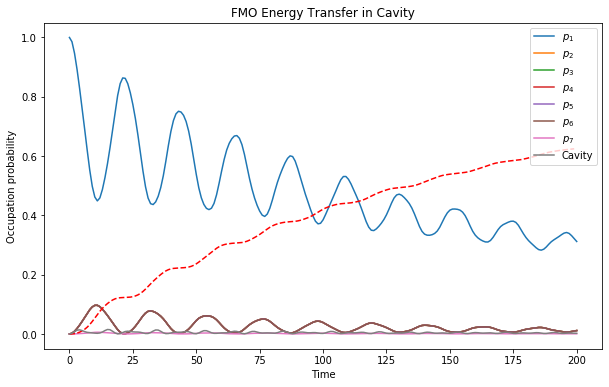

In [21]:
n_c = output.expect[0]
fig, axes = plt.subplots(1, 1, figsize=(10,6))

for i in range(n):
    axes.plot(tlist, output.expect[i + 1], label ='$p_{}$'.format(i + 1))
    
axes.plot(output.times[0:len(output.times) - 1], Gamma_c * 2 * scipy.integrate.cumtrapz(y = np.asarray(output.expect[n]), x = output.times, dx = dt), 'r--')

axes.plot(tlist, n_c, label="Cavity")
axes.legend(loc='upper right')
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('FMO Energy Transfer in Cavity')

# Quantum Fisher Information

In [22]:
class qfi(object):
    """quantum fisher information."""

    def __init__(self, state: qutip.qobj.Qobj, gen: qutip.qobj.Qobj) -> None:

        self.state = state   # state
        self.gen = gen       # generator

    def pure(self) -> float:
        """qfi pure state.

        outputs
        4fq: qfi"""

        # compute qfi
        fq = variance(self.gen, self.state)

        return 4*np.real(fq)

    def mixed(self) -> float:
        """qfi mixed state.

        outputs
        4fq: qfi"""

        # eigenvalues, eigenstates of density matrix
        evals, evecs = self.state.eigenstates()

        # initialize qfi
        fq: float = 0

        # compute qfi
        for i in np.arange(evals.shape[0]):
            for j in np.arange(i):
                if evals[i] + evals[j] > 0:
                    fq += ((evals[i] - evals[j])**2/(evals[i] + evals[j]))*np.abs(self.gen.matrix_element(evecs[i], evecs[j]))**2

        return 4*np.real(fq)

In [23]:
class objectives(object):
    """objectives to be optimized."""

    def __init__(self, model: object, state: qutip.qobj.Qobj, state_type: str) -> None:

        self.model = model
        self.state = state
        self.state_type = state_type

    def optimize_qfi(self, params: dict) -> float:
        """optimize qfi over bloch vectors."""

        # reformat bloch vectors to cartesian
        bloch_xyz = dict_to_arrays_bloch(params)

        # update generator
        self.model.generator(bloch_xyz)

        # qfi
        qfi_ = qfi(self.state, self.model.gen)

        if self.state_type == 'pure':
            cost = (qfi_.pure() + 1e-10)**(-1)

        if self.state_type == 'mixed':
            cost = (qfi_.mixed() + 1e-10)**(-1)

        # cost
        return cost

In [24]:
def optimize(objective: callable, params: dict, max_evals: int) -> dict:
    """bayesian optimization.
    
    objective: objective function
    params: parameters to be optimized
    max_evals: max iterations"""

    # create algorithm
    tpe_algo = tpe.suggest

    # create trials object, tracks results
    tpe_trials = Trials()

    # run with tpe algorithm
    tpe_best = fmin(fn=objective, space=params,
                    algo=tpe_algo, trials=tpe_trials,
                    max_evals=max_evals)

    return tpe_best

In [26]:
def bloch_params(na: int) -> dict:
    """bloch vectors domain for optimization.

    inputs
    na: number of atoms

    outputs
    params: dict of bloch vectors domain"""

    # initialize parameters domain
    params = {}

    # build parameters domain
    for i in range(na):

        params['bloch theta {}'.format(i)] = hp.uniform('bloch theta {}'.format(i), 0, 2*np.pi)
        params['bloch phi {}'.format(i)] = hp.uniform('bloch phi {}'.format(i), 0, np.pi)

    return params

In [27]:
def dict_to_arrays_bloch(params: dict) -> tuple:
    """convert dict to arrays.

    inputs
    params: hyperopt parameters"""

    # make array
    bloch_sph = np.asarray([v for k, v in params.items()])

    # split by angles
    bloch_sph = np.split(bloch_sph, 2)

    # convert spherical to cartesian
    [bloch_xyz] = spherical_to_cartesian([np.asarray(bloch_sph).T])

    # molecule info in rows
    return np.asarray(bloch_xyz)

In [28]:
def spherical_to_cartesian(sphs: list) -> np.ndarray:
    """convert spherical to cartesian coordinates."""

    c_lists = []

    for x in sphs:

        c_list = [[np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)] for phi, theta in x]
        c_lists.append(c_list)

    return c_lists

# Create Object Model

In [93]:
class model(object):
    """Quantum Rabi model with two-photon parametric driving."""

    def __init__(self, na: int, nc: int, wa: float, wc: float, g: float, use_rwa: bool) -> None:

        self.na = na                              # number qubits
        self.nc = nc                              # number cavity Fock states
        self.wa = wa                              # qubit frequency
        self.wc = wc                              # cavity mode frequency
        self.g = g                                # qubit-cavity interaction strength
        self.use_rwa = use_rwa                    # use rotating wave approximation

        self.si = qeye(2)                         # qubit identity operator
        self.ai = qeye(self.nc)                   # cavity mode identity operator

        self.op_list: list = []                   # operator list for constructing composite hamiltonian
        self.h: qutip.qobj.Qobj = 0               # composite hamiltonian
        self.a: qutip.qobj.Qobj = 0               # cavity, annihilation operator
        self.sms: list = []                       # qubits, lowering operators
        self.gen: qutip.qobj.Qobj = 0             # generator
        self.c_ops: list = []                     # collapse operators

    def qeye_op_list(self) -> None:
        """identity operator list of particles."""

        self.op_list = [self.si for _ in range(self.na)]
        self.op_list.extend([self.ai])

    def composite(self) -> None:
        """composite hamiltonian."""

        self.qeye_op_list()
        self.op_list[-1] = destroy(self.nc)
        self.a = tensor(self.op_list)
        self.h += self.wc * self.a.dag() * self.a

        for i in range(self.na):

            self.qeye_op_list()
            self.op_list[i] = destroy(2)
            sm = tensor(self.op_list)
            self.sms.append(sm)

            if self.use_rwa:
                self.h += self.wa * sm.dag() * sm + self.g * (self.a.dag() * sm + self.a * sm.dag())
            else:
                self.h += self.wa * sm.dag() * sm + self.g * (self.a.dag() + self.a) * (sm + sm.dag())
                
    def add_2photon_drive(self, r_max: float, tau: float) -> None:
        """add two-photon parametric drive.
        
        inputs
        r_max: max parametric gain
        tau: effective protocol speed"""
        
        lambda_ = '{0} * np.tanh( 2 * {1} * np.tanh( t / (2 * {2}) ) ) / 2'.format(self.wc, r_max, tau)
        self.h = [self.h, [-(self.a.dag() ** 2 + self.a ** 2), lambda_]] 

    def generator(self, bloch: np.ndarray) -> None:
        """generator for qfi.

        inputs
        bloch: qubit bloch vectors"""

        # reinitialize generator
        self.gen: qutip.qobj.Qobj = 0

        for i in range(self.na):
            self.qeye_op_list()
            self.op_list[i] = 0.5 * (bloch[i,0] * sigmax() + bloch[i,1] * sigmay() + bloch[i,2] * sigmaz())
            self.gen += tensor(self.op_list)

    def collapse_ops(self, qubit_diss: float, cavity_diss: float, n_cavity: float) -> None:
        """list of collpase operators.

        inputs
        qubit_diss: qubit dissipation rate
        cavity_diss: cavity relaxation rate
        n_cavity: average excitation thermal cavity"""

        # qubit dissipation
        rate = qubit_diss
        if rate > 0.0:
            for sm in self.sms:
                self.c_ops.append(np.sqrt(rate) * sm)

        # cavity relaxation
        rate = cavity_diss * (1 + n_cavity)
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a)

        # cavity excitation
        rate = cavity_diss * n_cavity
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a.dag())
            
            
            
    # take operators and extract states of interest and reduce to new operators in new subspace
    def soi_ops(self, soi: np.ndarray, state: qutip.qobj.Qobj) -> None:
        """operators written in terms of states of interest."""

        self.h_soi = self.h.extract_states(soi)
        self.state_soi = state.extract_states(soi)
        self.c_ops_soi = [c_op.extract_states(soi) for c_op in self.c_ops]
        self.gen_soi = self.gen.extract_states(soi)

In [94]:
def initiate_model(model_params: dict, drive_params: dict, collapse_params: dict) -> object:
    """initate model including 2 photon driving and collapse operators.
    
    model_params: model parameters
    drive_params: parametric driving parameters
    collapse params: collapse parameters"""
    
    model_ = model(**model_params)
    model_.composite()
    model_.add_2photon_drive(**drive_params)
    model_.collapse_ops(**collapse_params)
    
    return model_

In [95]:
class qfi(object):
    """quantum fisher information."""

    def __init__(self, state: qutip.qobj.Qobj, gen: qutip.qobj.Qobj) -> None:

        self.state = state   # state
        self.gen = gen       # generator

    def pure(self) -> float:
        """qfi pure state.

        outputs
        4fq: qfi"""

        # compute qfi
        fq = variance(self.gen, self.state)

        return 4*np.real(fq)

    def mixed(self) -> float:
        """qfi mixed state.

        outputs
        4fq: qfi"""

        # eigenvalues, eigenstates of density matrix
        evals, evecs = self.state.eigenstates()

        # initialize qfi
        fq: float = 0

        # compute qfi
        for i in np.arange(evals.shape[0]):
            for j in np.arange(i):
                if evals[i] + evals[j] > 0:
                    fq += ((evals[i] - evals[j])**2/(evals[i] + evals[j]))*np.abs(self.gen.matrix_element(evecs[i], evecs[j]))**2

        return 4*np.real(fq)

In [96]:
class objectives(object):
    """objectives to be optimized."""

    def __init__(self, model: object, state: qutip.qobj.Qobj, state_type: str) -> None:

        self.model = model
        self.state = state
        self.state_type = state_type

    def optimize_qfi(self, params: dict) -> float:
        """optimize qfi over bloch vectors."""

        # reformat bloch vectors to cartesian
        bloch_xyz = dict_to_arrays_bloch(params)

        # update generator
        self.model.generator(bloch_xyz)

        # qfi
        qfi_ = qfi(self.state, self.model.gen)

        if self.state_type == 'pure':
            cost = (qfi_.pure() + 1e-10)**(-1)

        if self.state_type == 'mixed':
            cost = (qfi_.mixed() + 1e-10)**(-1)

        # cost
        return cost

In [97]:
def optimize(objective: callable, params: dict, max_evals: int) -> dict:
    """bayesian optimization.
    
    objective: objective function
    params: parameters to be optimized
    max_evals: max iterations"""

    # create algorithm
    tpe_algo = tpe.suggest

    # create trials object, tracks results
    tpe_trials = Trials()

    # run with tpe algorithm
    tpe_best = fmin(fn=objective, space=params,
                    algo=tpe_algo, trials=tpe_trials,
                    max_evals=max_evals)

    return tpe_best

In [98]:
def bloch_params(na: int) -> dict:
    """bloch vectors domain for optimization.

    inputs
    na: number of atoms

    outputs
    params: dict of bloch vectors domain"""

    # initialize parameters domain
    params = {}

    # build parameters domain
    for i in range(na):

        params['bloch theta {}'.format(i)] = hp.uniform('bloch theta {}'.format(i), 0, 2*np.pi)
        params['bloch phi {}'.format(i)] = hp.uniform('bloch phi {}'.format(i), 0, np.pi)

    return params

In [99]:
def dict_to_arrays_bloch(params: dict) -> tuple:
    """convert dict to arrays.

    inputs
    params: hyperopt parameters"""

    # make array
    bloch_sph = np.asarray([v for k, v in params.items()])

    # split by angles
    bloch_sph = np.split(bloch_sph, 2)

    # convert spherical to cartesian
    [bloch_xyz] = spherical_to_cartesian([np.asarray(bloch_sph).T])

    # molecule info in rows
    return np.asarray(bloch_xyz)

In [100]:
def spherical_to_cartesian(sphs: list) -> np.ndarray:
    """convert spherical to cartesian coordinates."""

    c_lists = []

    for x in sphs:

        c_list = [[np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)] for phi, theta in x]
        c_lists.append(c_list)

    return c_lists

In [137]:
# parameters
model_params = {'na': 2, 'nc': 10, 'wa': 2 * np.pi, 'wc': 2 * np.pi, 'g': 0.2, 'use_rwa': False}
collapse_params = {'qubit_diss': 0.005, 'cavity_diss': 0.05, 'n_cavity': 0}
dyn_params = {'t_final': 50, 'num': 10000}
psi0 = tensor(basis(2,1), basis(2,0), basis(model_params['nc'], 0)).unit()
params = bloch_params(model_params['na'])
max_evals = 1000
tlist = np.linspace(0, dyn_params['t_final'], dyn_params['num'])
num_dpts = 20
idx = np.linspace(0, tlist.shape[0] - 1, num_dpts, dtype='int')
qfi_opt = np.zeros(num_dpts)

bloch_dipole = np.array([[1,0,0] for _ in range(model_.na)])

In [138]:
# construct model, run dynamics
model_ = model(**model_params)
model_.composite()
model_.collapse_ops(**collapse_params)

# execute the generator (general generator, eq 26)
model_.generator(bloch_dipole)

outputs_states = mesolve(model_.h, psi0, tlist, model_.c_ops, [])
outputs_e_ops = mesolve(model_.h, psi0, tlist, model_.c_ops, [model_.sms[0].dag()*model_.sms[0], model_.sms[1].dag()*model_.sms[1], model_.a.dag()*model_.a])

In [146]:
space = [2 for _ in range(model_.na)]
space.extend([model_.nc])

states = np.array(list(state_number_enumerate(space)))

# sum over excitations for each possible state
states_subspace = np.sum(states, axis = 1)

# restrict to 0/1 excitation subspace (states of interest)
soi = np.where((states_subspace==0) | (states_subspace==1) | (states_subspace==2))[0]

evals, evecs = model_.h.eigenstates()


model_.soi_ops(soi, evecs[1])

In [147]:
qfi_ = qfi(model_.state_soi, model_.gen_soi)
qfi_.pure()

3.034144407631051

In [141]:
qfi_ = qfi(evecs[1], model_.gen)
qfi_.pure()

3.035174841513363